# Notebook for Experimenting

In [2]:
import os
import json

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns

os.chdir('../src/')

from modules.config import Config
from modules.data import generate_features, load_data
from modules.pipeline_factory import get_pipeline_factory, AdjustedEstimator
from modules.training import train, evaluate

%load_ext autoreload
%autoreload 2

c:\Users\FLP-13-Rimba\miniconda3\envs\project-mix-design\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
FEATURES = [
    "age_days",
    "diameter",
    "height",
    "fas",
    "water",
    "cement",
    "sikacim_kg",
    "fine_aggregate_kg",
    "coarse_aggregate_kg",
    "area"
]

data_path = '../datasets/dataset.csv'
scheme_path = '../datasets/scheme.csv'

dataset = load_data(data_path, scheme_path, random_state=42, split=False)
train_set, test_set = load_data(data_path, scheme_path, random_state=42)

raw_data, df_scheme = load_data(
    dataset_path=data_path, scheme_path=scheme_path, raw=True
)

print(train_set.shape, test_set.shape)

train_set[['no', 'sample_code', 'scheme'] + FEATURES + ['weight']].round(2)

(110, 18) (22, 18)


,no,sample_code,scheme,age_days,diameter,height,fas,water,cement,sikacim_kg,fine_aggregate_kg,coarse_aggregate_kg,area,weight
0,1,a,0,1,150.70,301.40,0.5,205,408,0.00,715,1072,17836.78,225
1,2,b,0,1,150.48,302.10,0.5,205,408,0.00,715,1072,17784.74,225
2,3,c,0,1,151.54,302.45,0.5,205,408,0.00,715,1072,18036.18,220
3,4,d,0,3,148.80,303.10,0.5,205,408,0.00,715,1072,17389.85,410
4,5,e,0,3,148.76,302.40,0.5,205,408,0.00,715,1072,17380.50,380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,127,g,3C,7,150.25,303.50,0.5,164,326,6.52,764,1146,17730.41,505
106,128,h,3C,7,151.25,300.30,0.5,164,326,6.52,764,1146,17967.21,400
107,129,i,3C,7,148.80,300.50,0.5,164,326,6.52,764,1146,17389.85,455
108,131,k,3C,28,149.50,303.00,0.5,164,326,6.52,764,1146,17553.85,430


In [4]:
train_set.scheme.value_counts()

scheme
0       10
1A      10
1B      10
1C      10
2A      10
2B      10
2B-1    10
2C      10
3A      10
3B      10
3C      10
Name: count, dtype: int64

In [5]:
def evaluate_model(df, y_pred, threshold=0.2):
    assert len(df) == len(y_pred)

    result = df.copy()
    result["weight_pred"] = y_pred

    if 'weight' in df:
        y_true = df.weight
        result = result.drop("weight", axis=1)
        result["weight_true"] = y_true
        
        result["error"] = (result["weight_true"] - result["weight_pred"]) / result["weight_true"]
        result["abs_error"] = np.abs(result["error"])
        result["adjusted_error"] = (
            np.abs(result["weight_true"] - result["weight_pred"]) /
            np.abs(result["weight_true"] + result["weight_pred"])
        )
        result["quality"] = result["error"].apply(lambda x: 'good' if x <= threshold else 'bad')

    return result


def get_predictions(dataset, model):
    if isinstance(dataset, pd.DataFrame):
        predictions = dataset.copy()
    elif isinstance(dataset, pd.Series):
        predictions = dataset.to_frame().T
    
    y_pred = model.predict(predictions[model.feature_names_in_])
    return y_pred

# Testing with Trained Model

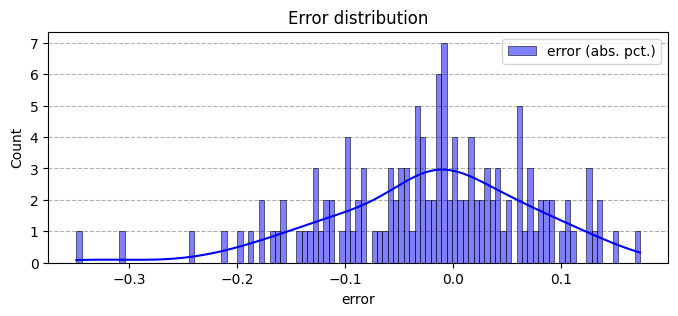

LR coef
age_days               124.749119
diameter                -3.376569
height                 -31.420970
fas                    -70.813834
water                  -30.106301
cement                  34.073810
sikacim_kg               0.261431
fine_aggregate_kg       -7.991981
coarse_aggregate_kg     -6.356161
area                    -3.522632
dtype: float64

XGB feature importance
age_days               0.626119
fas                    0.213149
cement                 0.072751
height                 0.030009
water                  0.026643
sikacim_kg             0.022706
diameter               0.008622
fine_aggregate_kg      0.000000
coarse_aggregate_kg    0.000000
area                   0.000000
dtype: float32


In [6]:
# load model
model_path_0088 = (
    "mlruns/510787892634627721/e1c21e006eba420ca18acde4f5c36ed3/artifacts/model"
)
model_path_0096 = (
    "mlruns/510787892634627721/3d639aa94677411c84a21216fb90c3ff/artifacts/model"
)
model_path_v6 = (
    "mlruns/430123908258705206/704931b304764d57ab947b44763e39ff/artifacts/model"
)

model = mlflow.sklearn.load_model(model_path_v6)

if isinstance(model, AdjustedEstimator):
    model.feature_names_in_ = FEATURES

# prepare data
X_train, y_train = train_set.drop("weight", axis=1), train_set.weight
X_test, y_test = test_set.drop("weight", axis=1), test_set.weight

# analyze result
y_pred = get_predictions(dataset, model)
predictions = evaluate_model(dataset, y_pred)

num_good = predictions[predictions["quality"] == "good"].shape[0]
num_bad = predictions[predictions["quality"] == "bad"].shape[0]

# plot error
fig, ax = plt.subplots(figsize=(8, 3))
sns.histplot(
    predictions,
    x="error",
    binwidth=0.005,
    kde=True,
    ax=ax,
    color="blue",
    alpha=0.5,
    label="error (abs. pct.)",
)

ax.set_title("Error distribution")
ax.legend()
ax.grid(linestyle='--', axis='y')
ax.set_axisbelow(True)
plt.show()

# feature importance
if isinstance(model, AdjustedEstimator):
    feature_importance = pd.Series(
        model.estimator.estimators_[0].named_steps['regressor'].feature_importances_,
        index=model.feature_names_in_,
    )
    coef = pd.Series(
        model.estimator.estimators_[1].named_steps['regressor'].coef_,
        index=model.feature_names_in_,
    )
    print('LR coef')
    print(coef)
else:
    feature_importance = pd.Series(
        model.named_steps["regressor"].feature_importances_,
        index=model.feature_names_in_,
    )

print('\nXGB feature importance')
print(feature_importance.sort_values(ascending=False))

In [56]:
# X_ = X_train[model.feature_names_in_]
# y_ = y_train
X_ = X_test[model.feature_names_in_]
y_ = y_test

if isinstance(model, AdjustedEstimator):
    old_multiplier = model.multiplier
    # model.multiplier = 1.2
    met = evaluate(model, X_, y_)
    for k, v in met.items():
        if isinstance(v, np.int64):
            met[k] = int(v)
    print(json.dumps(met, indent=4))
    model.multiplier = old_multiplier
else:
    met = evaluate(model, X_, y_)
    print(json.dumps(met, indent=4))

{
    "avg_ape": 0.10079901988891161,
    "max_ape": 0.30637141238125265,
    "p90_ape": 0.19415647207805775,
    "p95_ape": 0.2374716604801933,
    "avg_sape": 0.04849357742925262,
    "max_sape": 0.13283697965408542,
    "p90_sape": 0.08847341832897984,
    "p95_sape": 0.10611831893684272,
    "num_underestimate": 10
}


In [20]:
if isinstance(model, AdjustedEstimator):
    cols_to_select = [
        "scheme",
        "sample_code",
        "weight_true",
        "weight_pred",
        "error",
        "adjusted_error",
        "quality",
        "split"
    ]

    mul = model.multiplier
    # mul = 1.2
    y_pred = get_predictions(dataset, model)
    y_pred = y_pred * mul / model.multiplier
    predictions = evaluate_model(dataset, y_pred)
    
    num_good = predictions[predictions["quality"] == "good"].shape[0]
    num_bad = predictions[predictions["quality"] == "bad"].shape[0]
    num_underestimated = predictions[predictions.weight_true > predictions.weight_pred].shape[0]
    print(f"good: {num_good}, bad: {num_bad}, underestimated: {num_underestimated}")

    model.multiplier = mul

    met_train = evaluate(model, X_train[model.feature_names_in_], y_train)
    met_test = evaluate(model, X_test[model.feature_names_in_], y_test)

    for k, v in met_train.items():
        if isinstance(v, np.int64):
            met_train[k] = int(v)

    for k, v in met_test.items():
        if isinstance(v, np.int64):
            met_test[k] = int(v)

    print('Train metrics:')
    print(json.dumps(met_train, indent=4))
    print('Test metrics:')
    print(json.dumps(met_test, indent=4))

    model.multiplier = old_multiplier

    print(predictions[cols_to_select].sort_values(by="error"))

good: 132, bad: 0, underestimated: 54
Train metrics:
{
    "avg_ape": 0.06671006859524245,
    "max_ape": 0.3490209210249658,
    "p90_ape": 0.14013798257572044,
    "p95_ape": 0.1691737537967757,
    "avg_sape": 0.03265284525122722,
    "max_sape": 0.14858144425238873,
    "p90_sape": 0.06805431362572008,
    "p95_sape": 0.0812199419317169,
    "num_underestimate": 44
}
Test metrics:
{
    "avg_ape": 0.10079901988891161,
    "max_ape": 0.30637141238125265,
    "p90_ape": 0.19415647207805775,
    "p95_ape": 0.2374716604801933,
    "avg_sape": 0.04849357742925262,
    "max_sape": 0.13283697965408542,
    "p90_sape": 0.08847341832897984,
    "p95_sape": 0.10611831893684272,
    "num_underestimate": 10
}
    scheme sample_code  weight_true  weight_pred     error  adjusted_error  \
30      1B           g          360   485.647532 -0.349021        0.148581   
72    2B-1           a          325   424.570709 -0.306371        0.132837   
74    2B-1           c          295   365.681520 -0.239

In [21]:
predictions.loc[predictions.quality == 'bad', cols_to_select].sort_values(by='error')

,scheme,sample_code,weight_true,weight_pred,error,adjusted_error,quality,split


In [22]:
predictions.query("weight_pred < weight_true").loc[:, cols_to_select].sort_values('error')

,scheme,sample_code,weight_true,weight_pred,error,adjusted_error,quality,split
20,1A,i,500,499.738826,0.000522,0.000261,good,train
56,2A,i,560,559.459309,0.000966,0.000483,good,train
70,2B,k,930,927.085340,0.003134,0.001569,good,train
82,2B-1,k,780,776.107470,0.004990,0.002501,good,train
38,1C,c,220,218.000235,0.009090,0.004566,good,train
44,1C,i,505,499.792661,0.010312,0.005183,good,train
65,2B,f,620,611.943548,0.012994,0.006540,good,train
123,3C,d,435,428.480048,0.014988,0.007551,good,train
33,1B,j,680,669.326166,0.015697,0.007910,good,train
48,2A,a,310,304.626299,0.017335,0.008743,good,test


In [23]:
predictions.groupby('split').agg(
    {
        'abs_error': ['mean', 'std', 'max'],
        'adjusted_error': ['mean', 'std', 'max'],
    }
)

abs_error                     adjusted_error                    
           mean       std       max           mean       std       max
split                                                                 
test   0.100799  0.075824  0.306371       0.048494  0.033696  0.132837
train  0.066710  0.057674  0.349021       0.032653  0.027010  0.148581

# Manual Testing by Model

In [24]:
import warnings
warnings.filterwarnings('ignore')

config = Config(
    **{
        'experiment_name': 'v3',
        'algo': 'nn',
        'n_splits': 5,
        'n_repeats': 10,
        'use_height_as_feature': True,
        'age_days_as_categorical': False,
        'random_state': 42,
        'features': FEATURES
    }
)

params = {
    'activation': 'relu',
    'alpha': 0.03728096423300679,
    'beta_1': 0.07904805314839804,
    'beta_2': 0.0032265959783560057,
    'epsilon': 0.24893504448687376,
    'hidden_layer_sizes': (32,),
    'max_iter': 389,
    'random_state': 42,
    'solver': 'lbfgs'
}

pipeline_factory = get_pipeline_factory(config.algo)(config)

metrics, model = train(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    params=params,
    config=config,
    pipeline_factory=pipeline_factory
)

metrics = pd.Series(metrics)
metrics[['val_avg_avg_ape', 'val_max_max_ape', 'val_avg_avg_sape', 'val_max_max_sape']]

val_avg_avg_ape     0.201758
val_max_max_ape     1.150138
val_avg_avg_sape    0.093809
val_max_max_sape    0.394612
dtype: float64

In [25]:
y_pred = get_predictions(dataset, model)
predictions = evaluate_model(dataset, y_pred)

num_good = predictions[predictions['quality'] == 'good'].shape[0]
num_bad = predictions[predictions['quality'] == 'bad'].shape[0]

print(f'Good: {num_good}, Bad: {num_bad}')

predictions.sort_values(by='error', ascending=False)

Good: 119, Bad: 13


,no,sample_code,scheme,age_days,diameter,height,no_scheme,fas,water,cement,...,fine_aggregate_kg,coarse_aggregate_kg,area,split,weight_pred,weight_true,error,abs_error,adjusted_error,quality
32,33,i,1B,7,149.73,305.00,3,0.502451,205,408,...,715,1072,17607.898681,train,357.706456,535,0.331390,0.331390,0.198602,bad
104,105,i,3A,7,149.00,303.40,9,0.502475,203,404,...,717,1076,17436.624626,train,411.455476,610,0.325483,0.325483,0.194374,bad
31,32,h,1B,7,150.55,304.65,3,0.502451,205,408,...,715,1072,17801.286956,test,347.974435,505,0.310942,0.310942,0.184092,bad
102,103,g,3A,7,150.10,299.40,9,0.502475,203,404,...,717,1076,17695.028475,train,476.590450,690,0.309289,0.309289,0.182934,bad
101,102,f,3A,3,150.00,303.60,9,0.502475,203,404,...,717,1076,17671.458676,test,335.901677,485,0.307419,0.307419,0.181628,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,38,b,1C,1,149.00,301.10,4,0.502451,205,408,...,715,1072,17436.624626,test,374.750731,235,-0.594684,0.594684,0.229193,good
14,15,c,1A,1,150.70,300.50,2,0.502451,205,408,...,715,1072,17836.777136,train,371.690584,225,-0.651958,0.651958,0.245840,good
36,37,a,1C,1,150.15,300.50,4,0.502451,205,408,...,715,1072,17706.819265,train,363.587847,215,-0.691106,0.691106,0.256811,good
12,13,a,1A,1,149.66,302.20,2,0.502451,205,408,...,715,1072,17591.438856,train,356.244300,210,-0.696401,0.696401,0.258271,good


In [26]:
predictions[predictions.quality == 'bad'].sort_values(by='error')

,no,sample_code,scheme,age_days,diameter,height,no_scheme,fas,water,cement,...,fine_aggregate_kg,coarse_aggregate_kg,area,split,weight_pred,weight_true,error,abs_error,adjusted_error,quality
56,57,i,2A,7,149.25,302.20,5,0.497549,203,408,...,716,1073,17495.185876,train,447.838836,560,0.200288,0.200288,0.111289,bad
53,54,f,2A,3,150.35,300.10,5,0.497549,203,408,...,716,1073,17754.021695,test,421.017295,545,0.227491,0.227491,0.128344,bad
42,43,g,1C,7,150.63,303.50,4,0.502451,205,408,...,715,1072,17820.210654,train,361.790804,480,0.246269,0.246269,0.140426,bad
112,113,e,3B,3,150.10,303.00,10,0.501441,174,347,...,752,1127,17695.028475,train,305.235625,405,0.246332,0.246332,0.140467,bad
123,124,d,3C,3,150.55,299.00,11,0.503067,164,326,...,764,1146,17801.286956,train,323.231356,435,0.256939,0.256939,0.147407,bad
54,55,g,2A,7,149.50,303.30,5,0.497549,203,408,...,716,1073,17553.845301,train,418.191543,580,0.278980,0.278980,0.162102,bad
126,127,g,3C,7,150.25,303.50,11,0.503067,164,326,...,764,1146,17730.412626,train,357.319858,505,0.292436,0.292436,0.171259,bad
103,104,h,3A,7,150.50,299.70,9,0.502475,203,404,...,717,1076,17789.464750,train,461.420221,655,0.295542,0.295542,0.173393,bad
101,102,f,3A,3,150.00,303.60,9,0.502475,203,404,...,717,1076,17671.458676,test,335.901677,485,0.307419,0.307419,0.181628,bad
102,103,g,3A,7,150.10,299.40,9,0.502475,203,404,...,717,1076,17695.028475,train,476.590450,690,0.309289,0.309289,0.182934,bad


# Single Predictions

In [1]:
model = mlflow.sklearn.load_model(model_path_008)

feature_importance = pd.Series(
    model.named_steps['regressor'].feature_importances_,
    index=model.feature_names_in_
).sort_values(ascending=False)

feature_importance

NameError: name 'mlflow' is not defined

In [28]:
sample = pd.DataFrame(
    [
        {
            'age_days': 7,
            'diameter': 151.25,
            'height': 300.3,
            'scheme': '3C',
        },
        {
            'age_days': 14,
            'diameter': 151.25,
            'height': 300.3,
            'scheme': '3C',
        },
        {
            'age_days': 28,
            'diameter': 151.25,
            'height': 300.3,
            'scheme': '3C',
        },
    ]
)

sample = generate_features(sample, df_scheme)
y_pred = get_predictions(sample, model)

evaluate_model(sample, y_pred, threshold=0.2)

,age_days,diameter,height,scheme,no,fas,water,cement,slump,sikacim_pct,sikacim_kg,fine_aggregate_kg,coarse_aggregate_kg,area,weight_pred
0,7,151.25,300.3,3C,11,0.503067,164,326,10.0,2.0,6.52,764,1146,17967.210172,475.852631
1,14,151.25,300.3,3C,11,0.503067,164,326,10.0,2.0,6.52,764,1146,17967.210172,475.852631
2,28,151.25,300.3,3C,11,0.503067,164,326,10.0,2.0,6.52,764,1146,17967.210172,501.411285


# Generate Predictions

In [36]:
report = pd.read_csv('../datasets/report.csv', sep=';')

cols_to_select = [
    'no',
    'scheme',
    'age_days',
    'diameter',
    'height',
    'water',
    'fas',
    'cement',
    'fine_aggregate_kg',
    'coarse_aggregate_kg',
    'sikacim_kg',
    'load_prediction'
]

report_full = generate_features(report, df_scheme)
report_full['load_prediction'] = get_predictions(report_full, model)
report_full = report_full[cols_to_select]

report_full = report_full.rename(
    columns={
        'scheme': 'Skema',
        'age_days': 'Umur (Hari)',
        'diameter': 'Diameter (mm)',
        'height': 'Tinggi (mm)',
        'water': 'Kebutuhan air (kg)',
        'fas': 'fas',
        'cement': 'Kebutuhan semen (kg)',
        'fine_aggregate_kg': 'Kebutuhan agregat halus (kg)',
        'coarse_aggregate_kg': 'Kebutuhan agregat kasar (kg)',
        'sikacim_kg': 'Kebutuhan sikacim (kg)',
        'load_prediction': 'Prediksi (kN)'
    }
)

report_full.round(2)

,no,Skema,Umur (Hari),Diameter (mm),Tinggi (mm),Kebutuhan air (kg),fas,Kebutuhan semen (kg),Kebutuhan agregat halus (kg),Kebutuhan agregat kasar (kg),Kebutuhan sikacim (kg),Prediksi (kN)
0,1,0,1,150,300,205,0.50,408,715,1072,0.00,300.190002
1,2,0,3,150,300,205,0.50,408,715,1072,0.00,452.119995
2,3,0,7,150,300,205,0.50,408,715,1072,0.00,606.320007
3,4,0,14,150,300,205,0.50,408,715,1072,0.00,606.320007
4,5,0,28,150,300,205,0.50,408,715,1072,0.00,682.030029
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,6B,1,150,300,182,0.48,382,744,1116,3.27,322.660004
96,97,6B,3,150,300,182,0.48,382,744,1116,3.27,512.969971
97,98,6B,7,150,300,182,0.48,382,744,1116,3.27,612.320007
98,99,6B,14,150,300,182,0.48,382,744,1116,3.27,612.320007


In [39]:
df_scheme.drop(['slump', 'sikacim_pct'], axis=1)

,no,scheme,fas,water,cement,sikacim_kg,fine_aggregate_kg,coarse_aggregate_kg
0,1,0,0.502451,205,408,0.000,715,1072
1,2,1A,0.502451,205,408,0.816,715,1072
2,3,1B,0.502451,205,408,4.488,715,1072
3,4,1C,0.502451,205,408,8.160,715,1072
4,5,2A,0.497549,203,408,0.816,716,1073
5,6,2B,0.426471,174,408,4.488,727,1091
6,7,2B-1,0.470588,192,408,4.488,727,1091
7,8,2C,0.401961,164,408,8.160,731,1097
8,9,3A,0.502475,203,404,0.808,717,1076
9,10,3B,0.501441,174,347,3.817,752,1127


In [30]:
report_full.to_csv('../datasets/report_full.csv', index=False)